# Using OBIA for estimating area of Solar Panels in Spain

Using STAC, I am going to download imagery, segment the solar panels and estimate the area they occupy in the fields.

In [ ]:
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import Image
import leafmap.leafmap as leafmap

# Numerical and DataFrame libraries
import numpy as np
import pandas as pd
import dask.array as da

# Geospatial libraries
import geopandas as gpd
import shapely

# Raster libraries
import rasterio as rio
from rasterio.enums import Resampling
from rasterio import features
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import xarray as xr
import rioxarray
import stackstac
import pystac_client

# Image processing libraries
from skimage.color import label2rgb
from skimage.util import map_array
from skimage.segmentation import mark_boundaries, slic
from skimage.measure import regionprops_table, perimeter
from sklearn.ensemble import RandomForestClassifier

# Custom (src) libraries
from src.utils import stretch_histogram, normalize, calculate_iou
from src.indices import ndvi_calc, ndbi_calc
from src.obia import std, entropy_ndvi, rectangularity, compactness

In [ ]:
#Set api address and check collections
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [ ]:
collection = 'sentinel-2-l2a'

#coordinates AOI
lat = 37.364
lon = -6.923
point = shapely.geometry.Point(lon, lat)
date_range = '2025-04-01/2025-05-16'

In [5]:
search = client.search(
    collections = [collection],
    intersects=point,
    datetime=date_range,
    query = ['eo:cloud_cover<10']
)

items = search.item_collection()
len(items)

2

In [6]:
item_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs = 'EPSG:4326')
item_df 

geometry  \
0  POLYGON ((-7.69213 37.94031, -7.87145 37.3139,...   
1  POLYGON ((-7.69554 37.94035, -7.87124 37.32824...   

                    created     platform constellation instruments  \
0  2025-05-15T15:21:11.337Z  sentinel-2b    sentinel-2       [msi]   
1  2025-04-22T19:32:50.586Z  sentinel-2a    sentinel-2       [msi]   

   eo:cloud_cover                       proj:centroid  mgrs:utm_zone  \
0        6.094903  {'lat': 37.42613, 'lon': -7.22372}             29   
1        4.524603   {'lat': 37.42651, 'lon': -7.2248}             29   

  mgrs:latitude_band mgrs:grid_square  ...  \
0                  S               PB  ...   
1                  S               PB  ...   

                                     s2:datastrip_id  \
0  S2B_OPER_MSI_L2A_DS_2BPS_20250515T135717_S2025...   
1  S2A_OPER_MSI_L2A_DS_2APS_20250422T180305_S2025...   

   s2:reflectance_conversion_factor                     datetime  s2:sequence  \
0                          0.980395  2025-05-15T11:20:58.831000Z            0   
1                          0.992053  2025-04-22T11:21:12.566000Z            0   

                                 earthsearch:s3_path  \
0  s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...   
1  s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...   

                              earthsearch:payload_id  \
0  roda-sentinel2/workflow-sentinel2-to-stac/f069...   
1  roda-sentinel2/workflow-sentinel2-to-stac/0950...   

   earthsearch:boa_offset_applied                  processing:software  \
0                            True  {'sentinel2-to-stac': '2025.03.06'}   
1                            True  {'sentinel2-to-stac': '2025.03.06'}   

                    updated   proj:code  
0  2025-05-15T15:21:11.337Z  EPSG:32629  
1  2025-04-22T19:32:50.586Z  EPSG:32629  

[2 rows x 44 columns]

In [7]:
item_df['s2:nodata_pixel_percentage']

0    4.252186
1    4.083012
Name: s2:nodata_pixel_percentage, dtype: float64

In [ ]:
item_df.explore() #plotting image footprint

In [ ]:
#filtering to check the date
ids= item_df.loc[
  (item_df['eo:cloud_cover'] <= 5) &
  (item_df['s2:nodata_pixel_percentage'] <= 4.1)
]

item = items[ids.index[0]]
item.datetime

datetime.datetime(2025, 4, 22, 11, 21, 12, 566000, tzinfo=tzutc())

In [ ]:
#loading aoi shape
aoi = gpd.read_file('solar_aoi.json')
bbox = aoi.total_bounds
aoi.explore()

In [11]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

In [ ]:
#generating cube
assets = ["red","green","blue","nir", 'swir16', "scl"]
cube_all = stackstac.stack(
    item, 
    assets, 
    bounds_latlon = bbox, 
    epsg=32629
    )
scl = cube_all.sel(band=["scl"])
s2_mask = da.isin(scl, [3,8,9])
cube = cube_all.where(~s2_mask)
cube = cube.to_dataset(dim = 'band')

In [13]:
cube

<xarray.Dataset> Size: 3MB
Dimensions:                                  (time: 1, y: 263, x: 267, band: 6)
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 8B 2025-04...
    id                                       (time) <U24 96B 'S2A_29SPB_20250...
  * x                                        (x) float64 2kB 6.829e+05 ... 6....
  * y                                        (y) float64 2kB 4.138e+06 ... 4....
    s2:medium_proba_clouds_percentage        float64 8B 2.462
    mgrs:grid_square                         <U2 8B 'PB'
    ...                                       ...
    title                                    (band) <U30 720B 'Red - 10m' ......
    gsd                                      (band) int64 48B 10 10 10 10 20 20
    common_name                              (band) object 48B 'red' ... None
    center_wavelength                        (band) object 48B 0.665 ... None
    full_width_half_max                      (band) object 48B 0.038 ... None
    epsg                                     int64 8B 32629
Dimensions without coordinates: band
Data variables:
    red                                      (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
    green                                    (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
    blue                                     (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
    nir                                      (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
    swir16                                   (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
    scl                                      (time, y, x) float64 562kB dask.array<chunksize=(1, 263, 267), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=32629, bounds=(682890.4628978119, 4135732...
    crs:            epsg:32629
    transform:      | 10.37, 0.00, 682890.46|\n| 0.00,-10.35, 4138455.25|\n| ...
    resolution_xy:  (10.371969363575515, 10.353929459115403)

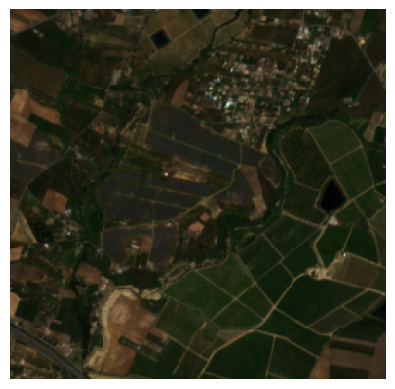

In [ ]:
#stacking to have RGB composition
rgb = np.dstack((
    normalize(cube['red'][0,:,:]),
    normalize(cube['green'][0,:,:]),
    normalize(cube['blue'][0,:,:])
    )
)
plt.imshow(rgb)
plt.axis('off')
plt.show()

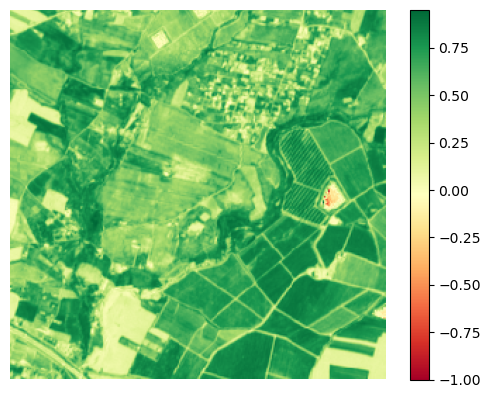

In [15]:
#calculate NDVI
ndvi = ndvi_calc(
    normalize(cube.red), 
    normalize(cube.nir)
    )

plt.imshow(ndvi[0,:, :], cmap = 'RdYlGn', vmin = -1, vmax = 0.95)
plt.colorbar()
plt.axis('off')
plt.show()

In [16]:
#Adding NDVI to the datacube
cube['ndvi'] = ndvi

In [ ]:
#generating agriculture composition
agriculture = np.dstack((
    normalize(cube.swir16[0, ...]),
    normalize(cube.nir[0, ...]),
    normalize(cube.blue[0, ...])
))

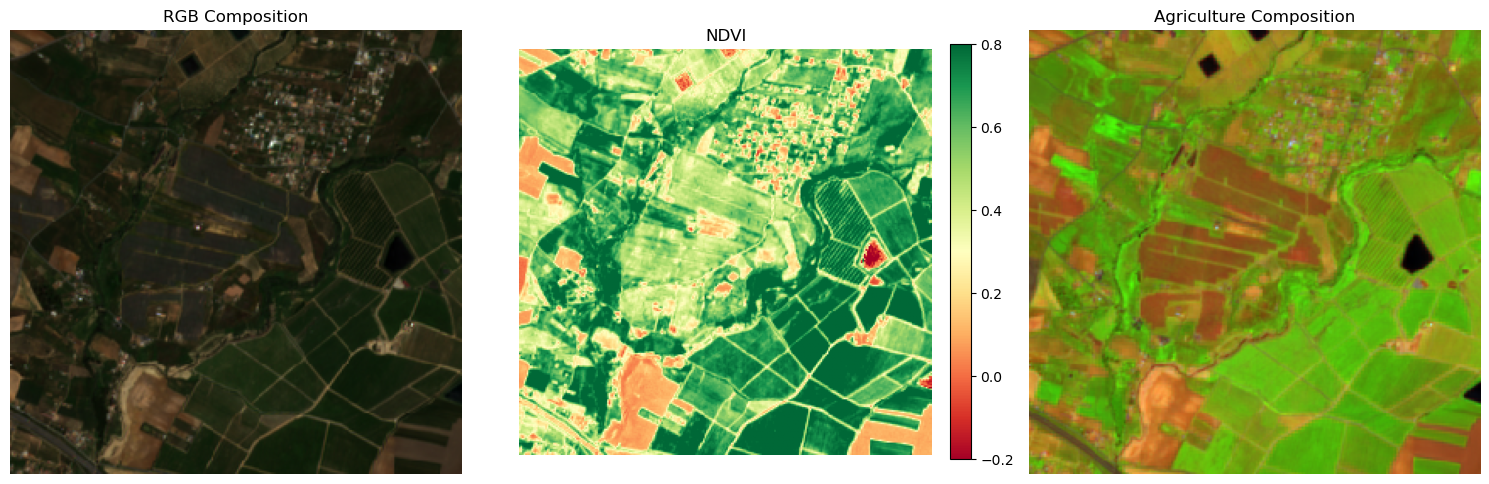

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,8))


ax[0].imshow(rgb)
ax[0].set_title('RGB Composition')

#NDVI Plot
im = ax[1].imshow(cube.ndvi[0,...], cmap ='RdYlGn', vmin = -0.2, vmax = 0.8)
ax[1].set_title('NDVI')
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

#Agriculture Plot
ax[2].imshow(agriculture)
ax[2].set_title('Agriculture Composition')

for axis in ax:
    axis.set_axis_off()

plt.tight_layout()
#plt.savefig('solar_panels.png', dpi = 300)

plt.show()


# Image Segmentation

In [19]:
n_segments = 1000
compactness = 8

segments = slic(rgb, n_segments=n_segments, compactness=compactness, start_label=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


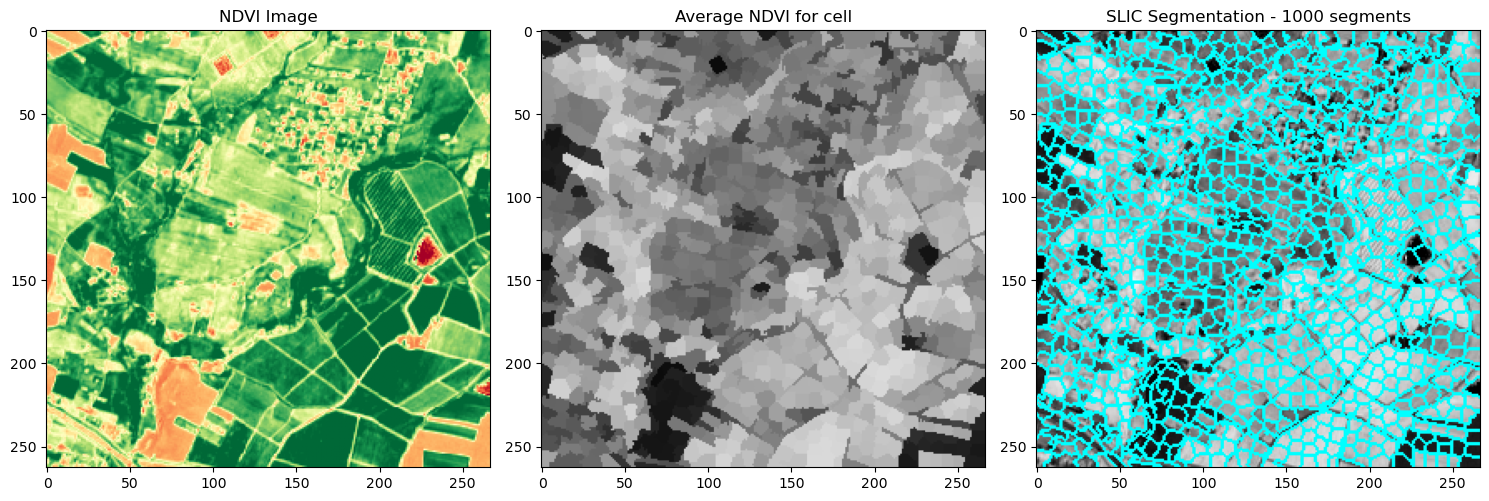

In [20]:
ndvi = cube.ndvi[0,...].to_numpy()

fig, ax = plt.subplots(nrows = 1, ncols=3, figsize = (15,10))

ax[0].imshow(cube.ndvi[0,...], cmap="RdYlGn", vmin = -0.2, vmax = 0.8)
ax[0].set_title('NDVI Image')

ax[1].imshow(label2rgb(segments, ndvi, kind='avg'), cmap="RdYlGn")
ax[1].set_title('Average NDVI for cell')

ax[2].imshow(mark_boundaries(
    ndvi, segments, color = (0,1,1), mode = "thick"
    ), vmin = -0.2, 
    vmax = 0.8, 
    cmap = 'RdYlGn'
)
ax[2].set_title(f"SLIC Segmentation - {n_segments} segments")

plt.tight_layout()
plt.show()  

In [ ]:
#generating a stack from the cube's bands

red_band = cube.red[0,...].to_numpy() # Shape: (273, 277)
blue_band = cube.blue[0,...].to_numpy() # Shape: (273, 277)
green_band = cube.green[0,...].to_numpy() # Shape: (273, 277)
nir_band = cube.nir[0,...].to_numpy() # Shape: (273, 277)
swir16_band = cube.swir16[0,...].to_numpy() # Shape: (273, 277)
ndvi_band = cube.ndvi[0,...].to_numpy() # Shape: (273, 277)

class_stack = np.stack([
    red_band,
    blue_band,
    green_band,
    nir_band,
    ndvi_band
], axis=-1)

In [23]:
print(f"Shape of segments before calc_all_feats: {segments.shape}")
print(f"Dtype of segments before calc_all_feats: {segments.dtype}")
print(f'Class Stack Shape: {class_stack.shape}')

Shape of segments before calc_all_feats: (263, 267)
Dtype of segments before calc_all_feats: int64
Class Stack Shape: (263, 267, 5)


In [ ]:
#calculating object properties
spectral_feats = pd.DataFrame(
        regionprops_table(
            label_image = segments,
            intensity_image = class_stack,
            properties = ["label", "intensity_mean"],
            extra_properties=(std,)
        )
    )

textural_feats = pd.DataFrame(
    regionprops_table(
        label_image = segments,
        intensity_image =class_stack[:, :, -1],  # Use only the NDVI band
        properties = [],
        extra_properties=(entropy_ndvi,)
    )
)

all_feats = pd.concat([spectral_feats, textural_feats], axis=1)


In [120]:
all_feats

label  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0        1          0.027862         -0.042910         -0.001238   
1        2          0.080568         -0.032276          0.016865   
2        3         -0.044666         -0.067834         -0.034412   
3        4          0.025064         -0.021350          0.011151   
4        5          0.040373         -0.002245          0.023704   
..     ...               ...               ...               ...   
973    974          0.024490         -0.032016         -0.004268   
974    975         -0.066972         -0.076197         -0.034348   
975    976         -0.040870         -0.066536         -0.034127   
976    977          0.048115         -0.015065          0.028035   
977    978          0.146918          0.023862          0.097262   

     intensity_mean-3  intensity_mean-4     std-0     std-1     std-2  \
0            0.171266          0.319099  0.019682  0.007100  0.008637   
1            0.147812          0.108966  0.019190  0.012957  0.015998   
2            0.231666          0.705553  0.013978  0.007132  0.006700   
3            0.164031          0.323402  0.034899  0.024833  0.024730   
4            0.138447          0.215724  0.039480  0.025176  0.023874   
..                ...               ...       ...       ...       ...   
973          0.073139          0.115271  0.005323  0.005199  0.005485   
974          0.302340          0.853756  0.002288  0.001580  0.001706   
975          0.224800          0.681801  0.010581  0.005527  0.005564   
976          0.207080          0.314950  0.033702  0.012500  0.023173   
977          0.273518          0.159989  0.031303  0.013685  0.021845   

        std-3     std-4  entropy_ndvi  
0    0.029876  0.119720      2.606259  
1    0.021437  0.045572      1.089907  
2    0.031923  0.082560      2.356665  
3    0.038379  0.147988      3.261779  
4    0.048683  0.177609      3.058391  
..        ...       ...           ...  
973  0.009785  0.034597      1.093901  
974  0.005944  0.011986      1.022169  
975  0.018288  0.064739      2.147613  
976  0.044281  0.065519      2.323484  
977  0.015553  0.062945      1.989401  

[978 rows x 12 columns]

# Train - Test

In [121]:
#Transforming the segments to geopandas polygons
segments_int = segments.astype('uint16')
find_shapes = features.shapes(segments_int, transform=cube.transform)

geoms_and_ids = [
    (shapely.geometry.shape(geom), value) for geom, value in features.shapes(segments_int, transform=cube.transform)
    ]

# Unzip into separate lists
polygons, segment_ids = zip(*geoms_and_ids)

crs = {'init': cube.crs}

my_gdf = gpd.GeoDataFrame({'segment_ids': segment_ids, 'geometry':polygons}, crs=crs)

my_gdf.head()

segment_ids                                           geometry
0          8.0  POLYGON ((683782.452 4138455.251, 683782.452 4...
1          3.0  POLYGON ((683066.786 4138455.251, 683066.786 4...
2         13.0  POLYGON ((684228.447 4138455.251, 684228.447 4...
3          6.0  POLYGON ((683502.409 4138455.251, 683502.409 4...
4          2.0  POLYGON ((682931.951 4138455.251, 682931.951 4...

In [ ]:
#chaging the crs from UTM to GMS
my_gdf.to_crs('epsg:4326', inplace = True)

In [ ]:
m = leafmap.Map()

m.add_gdf(my_gdf, layer_name="SLIC Segments")
m

In [ ]:
#Super pixels classes
solar_panels_idx = [
    376, 422, 648, 365, 605, 489, 331, 390, 672, 490, 352, 626, 640 , 395, 595, 276,
    456, 502, 342, 382, 509, 540, 423, 344
]

non_solar_idx = [
    336, 415, 266, 241, 368, 515, 555, 750, 416, 815, 849, 866, 957, 239, 226, 290,323, 470,
    566, 547,516, 710, 539, 797, 285, 919, 888, 909, 784, 77, 834, 772, 870, 778, 974,
    963, 405, 372, 607, 683, 609, 620, 622, 642,443,438
] 

In [ ]:
#Setting all classes to -1
all_feats['class'] = -1

#If it is a solar panel cell, then class 1
all_feats.loc[all_feats['label'].isin(solar_panels_idx), 'class'] = 1

#If it is NOT a solar panel cell, then class 0
all_feats.loc[all_feats['label'].isin(non_solar_idx), 'class'] = 0

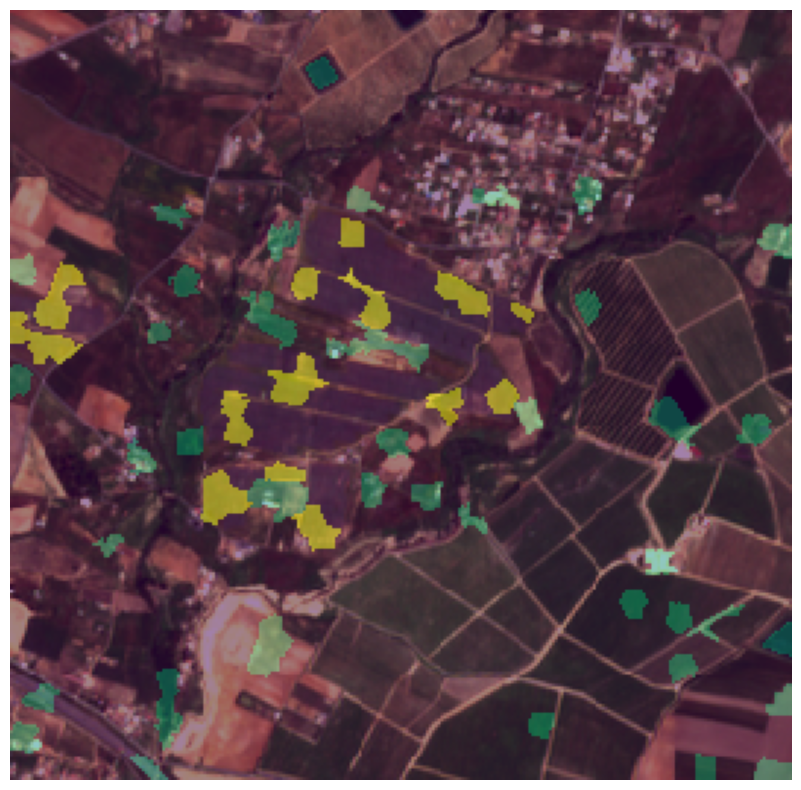

In [ ]:
#mapping the samples to the segments
mapped_samples = map_array(
    segments, 
    np.array(all_feats['label']),
    np.array(all_feats['class'])
)

#stretching the rgb image to improve viz
rgb_stretch = stretch_histogram(rgb, np.min(rgb), np.max(rgb))

plt.figure(figsize=(20,10))
plt.imshow(rgb_stretch)
plt.imshow(mapped_samples, alpha = 0.5)

plt.axis('off')
plt.show()

In [ ]:
#Start training
labeled_segments = all_feats[all_feats['class'] != -1]

X_train = labeled_segments.drop(columns = ['label','class'])
y_train = labeled_segments['class']

clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
clf.fit(X_train,y_train)

print('OOB Score:', clf.oob_score_)

OOB Score: 0.9428571428571428


In [130]:
# Filter out the unlabeled segments
unlabeled_segments_df = all_feats[all_feats['class'] == -1]

# Separate features (X) for the unlabeled segments
X_test = unlabeled_segments_df.drop(columns=['label', 'class'])

# Predict the class labels for the unlabeled segments
predictions = clf.predict(X_test)

# Update the original dataframe with the predictions
all_feats.loc[all_feats['class'] == -1, 'class'] = predictions

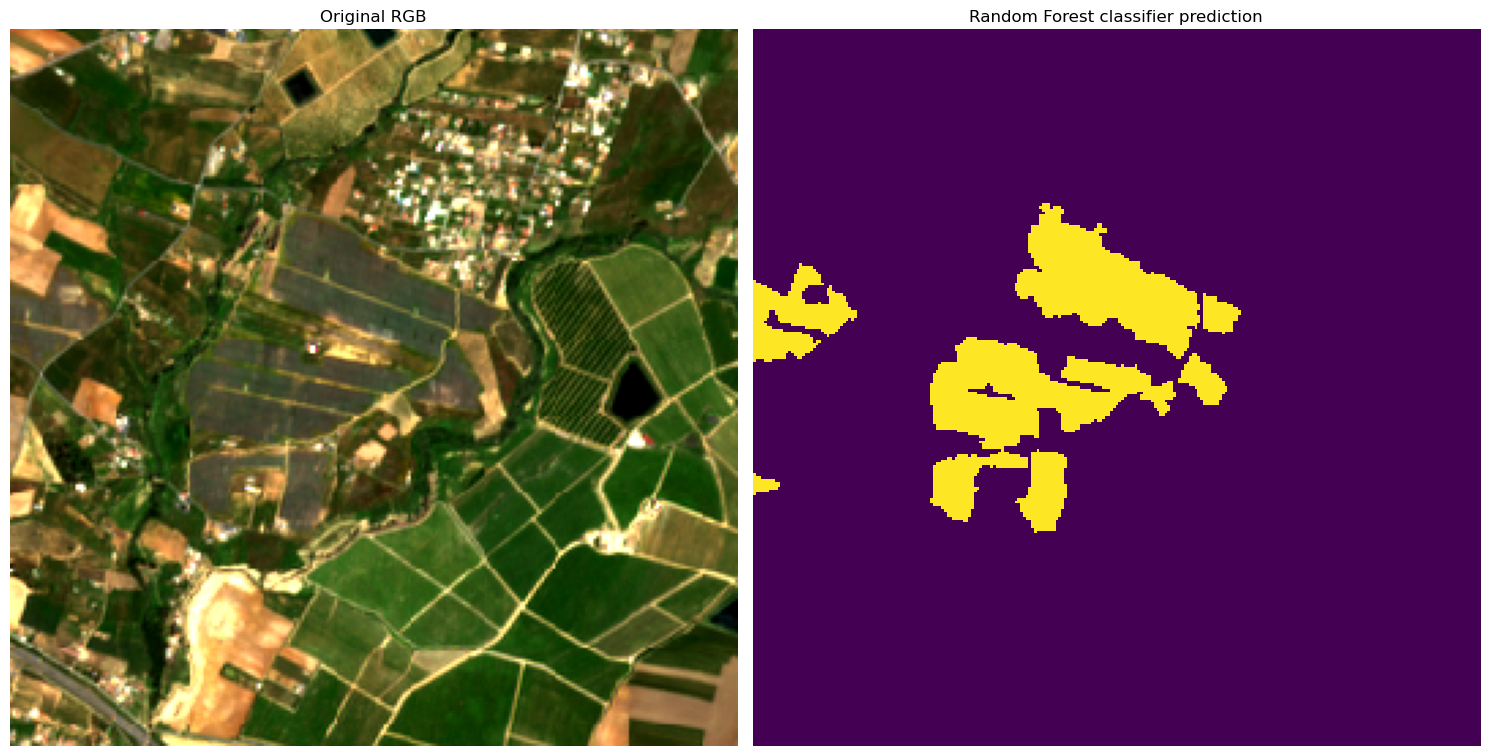

In [131]:
mapped_rf_classification= map_array(
    segments,
    np.array(all_feats["label"]),
    np.array(all_feats["class"]))

fig, axs = plt.subplots(ncols=2, figsize=(15, 10), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb_stretch)
axs[0].set_title("Original RGB")

# Display the prediction result
axs[1].imshow(mapped_rf_classification, interpolation="nearest")
axs[1].set_title("Random Forest classifier prediction")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.tight_layout()
plt.show()


## Evaluation

Taking the solar panel area from OSM to be the ground truth. 

It was downloaded with QuickOSM and processed in QGIS.

In [170]:
with rio.open('./ground_truth.tif', 'r') as file:
    gt = file.read()
    gt_metadata = file.profile



In [171]:
gt = np.transpose(gt, (1,2,0))
output = np.expand_dims(mapped_rf_classification, axis = -1)
gt.shape == output.shape #Should return true

True

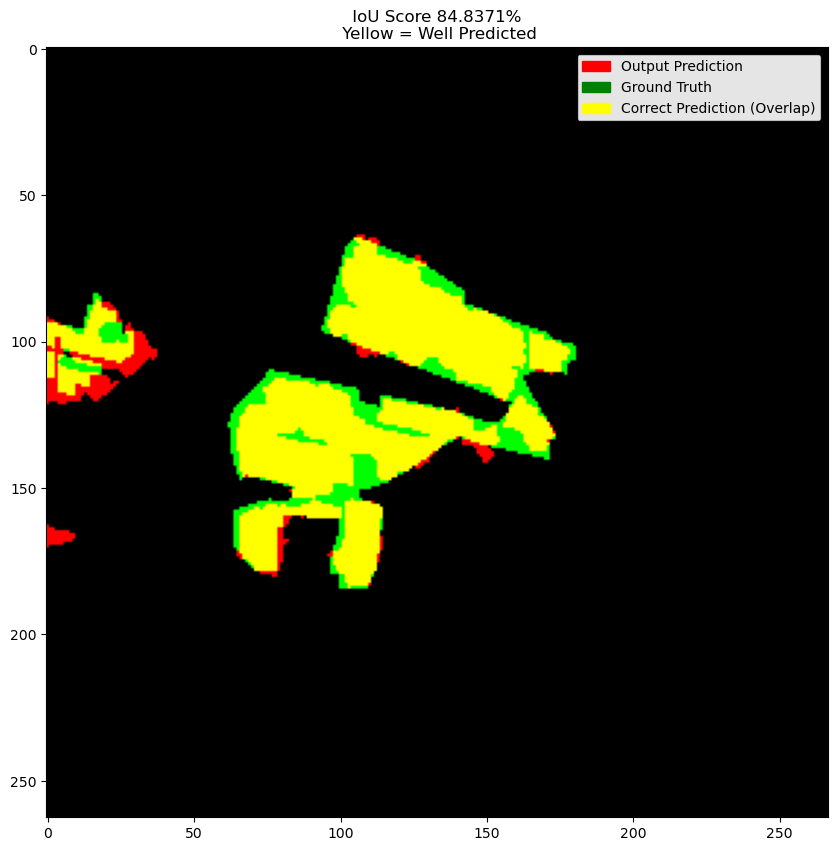

In [ ]:

plt.figure(figsize = (20,10))
stack = np.dstack([
    output, #red
    gt, #green
    np.zeros_like(output)
])

#plot image
plt.imshow(stack)

#calculate iou
iou = calculate_iou(gt, output)

#set title
plt.title(f' IoU Score {iou:.4f}% \n Yellow = Well Predicted');

#configure legend
red_patch = mpatches.Patch(color='red', label='Output Prediction')
green_patch = mpatches.Patch(color='green', label='Ground Truth')
yellow_patch = mpatches.Patch(color='yellow', label='Correct Prediction (Overlap)')

# Add the legend to the plot
plt.legend(handles=[red_patch, green_patch, yellow_patch],
           loc='upper right', 
           facecolor='white', 
           framealpha=0.9,    
           edgecolor='black') 

plt.show()